In [5]:
#####################################################################
## Machine learning for anomaly detection and condition monitoring ##
## Sources: https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7
##          https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770
#####################################################################

### To run Jupyter from virtual environment, I excuted: ###
# (env) install ipykernel
# ipython kernel install --user --name=env
# jupyter notebook
#-- Sources: https://github.com/jupyter/notebook/issues/1558 (comment: DaehanKim)
#            https://medium.com/@eleroy/jupyter-notebook-in-a-virtual-environment-virtualenv-8f3c3448247

#Import libraries
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

### DATA LOADING AND PRE-PROCESSING
2nd_test folder has 984 files of logged data. The data of all these files are merged into one single file: 'merged_dataset_BearingTest_2.csv'

In [6]:
### DATA LOADING AND PRE-PROCESSING
data_dir = "C:/Users/alvar/Machine_learning_for_anomaly_detection_and_condition_monitoring/env/2nd_test"
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


### DEFINE TRAIN/TEST DATA

<AxesSubplot:>

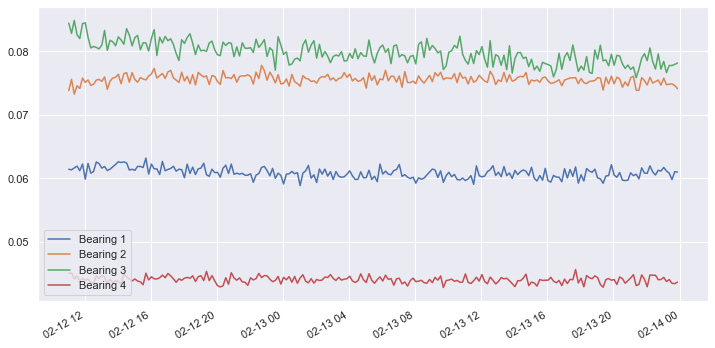

In [31]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
# dataset_test = merged_data['2004-02-13 23:52:39':'2004-02-14 23:52:39']
dataset_train.plot(figsize = (12,6))

### NORMALIZE DATA

In [40]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                                  columns=dataset_train.columns, 
                                  index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

# X_train.head(), X_test.head()
# dataset_test.head(20)
X_test.head(20)
# X_train.head(20)
# X_test.to_csv('normalised_data.csv')

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-13 23:52:39,0.489779,0.187746,0.255713,0.298511
2004-02-14 00:02:39,0.354621,0.227843,0.244457,0.425398
2004-02-14 00:12:39,0.249681,0.309895,0.231099,0.254432
2004-02-14 00:22:39,0.303792,0.376130,0.195196,0.608553
2004-02-14 00:32:39,0.610786,0.502812,0.162301,0.380454
2004-02-14 00:42:39,0.529085,0.482677,0.346399,0.589664
2004-02-14 00:52:39,0.456810,0.391719,0.022376,0.656198
2004-02-14 01:02:39,0.544814,0.325182,0.355840,0.863937
2004-02-14 01:12:39,0.260686,0.394893,-0.074461,0.345551
2004-02-14 01:22:39,0.605137,0.423924,0.299409,0.909903


### DEFINE THE AUTOENCODER NETWORK

In [10]:
seed(10)
tf.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

## FITTING THE MODEL

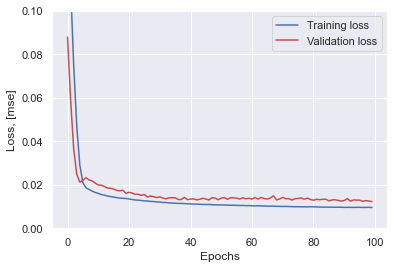

In [11]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 0)


### VISUALIZE TRAINING/VALIDATION LOSS
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

### DISTRIBUTION OF LOSS FUNCTION IN THE TRAINING SET
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.
From the above loss distribution, let us try a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

(0.0, 0.5)

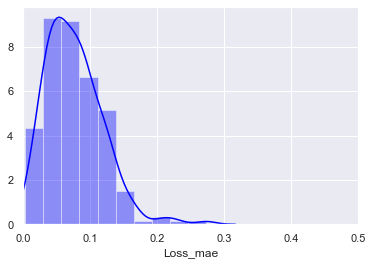

In [12]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

The test dataset will now be labelled as non-anomaly or anomaly based on the threshold set above

In [25]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

# scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
# plt.show()

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.135230,0.3,False
2004-02-14 00:02:39,0.103883,0.3,False
2004-02-14 00:12:39,0.031544,0.3,False
2004-02-14 00:22:39,0.072124,0.3,False
2004-02-14 00:32:39,0.120766,0.3,False


We then calculate the same metrics also for the training set, and merge all data in a single dataframe:

In [16]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

### Results from Autoencoder model
Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure:

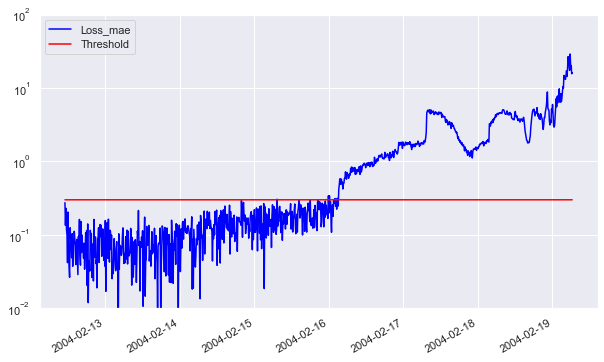

In [17]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
plt.show()

In [21]:
filepath = "C:/Users/alvar/Machine_learning_for_anomaly_detection_and_condition_monitoring/env/model"
model.save(filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/alvar/Machine_learning_for_anomaly_detection_and_condition_monitoring/env/model\assets


In [22]:
#https://www.tensorflow.org/guide/keras/save_and_serialize
from tensorflow import keras
samemodel = keras.models.load_model(filepath)

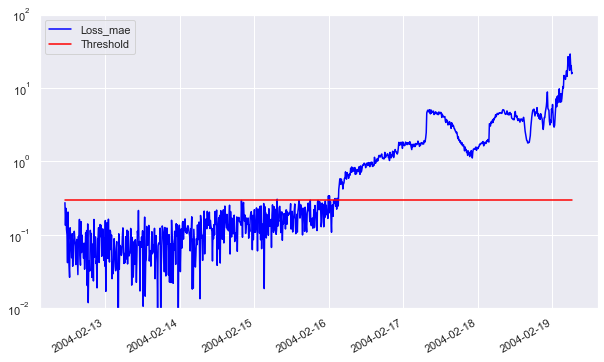

In [23]:
X_pred = samemodel.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
plt.show()

In [26]:
import tensorflow as tf
from keras.models import load_model
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
import matplotlib.pyplot as plt

class autoencoder:

    def __init__(self):
        path2model = 'C:/Users/alvar/Machine_learning_for_anomaly_detection_and_condition_monitoring/env/model'
        self.anomaly_detected = None      
        self.__model = load_model(path2model)
        self.__data_loading()

    
    def __data_loading(self):
        dataset_dir = "C:/Users/alvar/Machine_learning_for_anomaly_detection_and_condition_monitoring/env/2nd_test"
        self.__merged_data = pd.DataFrame()

        for filename in os.listdir(dataset_dir):
            dataset=pd.read_csv(os.path.join(dataset_dir, filename), sep='\t')
            dataset_mean_abs = np.array(dataset.abs().mean())
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
            dataset_mean_abs.index = [filename]
            self.__merged_data = self.__merged_data.append(dataset_mean_abs)

        self.__merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
        self.__merged_data.index = pd.to_datetime(self.__merged_data.index, format='%Y.%m.%d.%H.%M.%S')
        self.__merged_data = self.__merged_data.sort_index()
        # print(self.__merged_data.head(20))
        self.__merged_data = self.__merged_data['2004-02-18 23:52:39':'2004-02-19 00:32:39']
                                                 
        self.__normalize_data()


    def __normalize_data(self):
        # print(self.__merged_data.head(20))
        scaler = preprocessing.MinMaxScaler()
        self.__data = pd.DataFrame(scaler.fit_transform(self.__merged_data), 
                                   columns=self.__merged_data.columns, 
                                   index=self.__merged_data.index
                                   )
        print(self.__data.head(20))
        self.__detect_anomaly()
    

    def __detect_anomaly(self):
        pred = self.__model.predict(np.array(self.__data))
        pred = pd.DataFrame(pred,
                            columns=self.__data.columns
                            )
        pred.index = self.__data.index
        scored = pd.DataFrame(index=self.__data.index)
        scored['Loss_mae'] = np.mean(np.abs(pred - self.__data), axis = 1)
        scored['Threshold'] = .25
        scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
        self.anomaly_detected = scored['Anomaly']
        self.anomaly_detected = {'Loss_mae':scored['Loss_mae'],
                                 'anomaly_detected':scored['Anomaly']
                                }

        # print(scored['Loss_mae'].head(20))
        scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
        plt.show()

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-18 23:52:39   0.597174   0.599286   0.026786   0.368288
2004-02-19 00:02:39   1.000000   0.689326   0.123587   1.000000
2004-02-19 00:12:39   0.517423   1.000000   1.000000   0.985383
2004-02-19 00:22:39   0.157521   0.768634   0.908275   0.271748
2004-02-19 00:32:39   0.000000   0.000000   0.000000   0.000000


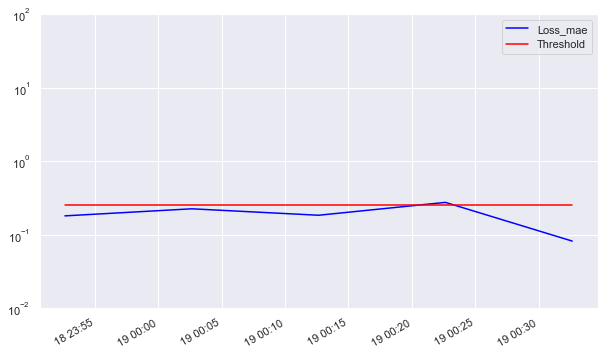

In [28]:
# from condition_monitoring import condition_monitoring as cm

anomaly_detection = autoencoder()